In [0]:
# RUN THIS LINE ONLY ONCE !!!
import sys
import os
os.chdir('../')
sys.path.append(os.getcwd())

In [1]:
!pip install gputil
import psutil
import humanize
import os
import GPUtil as GPU

GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7413 sha256=5c4152ce5f37c006d9243d6f969f8abd115a2be5471ab39554257080c75a2cae
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Gen RAM Free: 12.8 GB  | Proc size: 159.6 MB
GPU RAM Free: 11441MB | Used: 0MB | Util   0% | Total 11441MB


In [0]:
from utils import get_dataset, validate
from learner import Learner
from schedulers import CyclicLRDecay
import random
import torch
import torch.nn as nn
from torch.optim import AdamW

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
torch.cuda.get_device_name(device)

'Tesla K80'

In [0]:
# Setup logger
import logging
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(levelname)s : %(message)s', datefmt='%m/%d/%Y %H:%M:%S')  

In [0]:
# If you have dark theme
from matplotlib.pyplot import rcParams
rcParams['figure.facecolor'] = 'white'

In [7]:
dataset, test_dataset, emb_weights = get_dataset(min_freq=5, test_set=True)
dataset.fields['review'].include_lengths = True

random.seed(35)
ds_train, ds_val = dataset.split(split_ratio=[0.9, 0.1])

06/10/2020 16:40:10 INFO : ----- IMDb dataset -----
06/10/2020 16:40:10 INFO : Downloading data
06/10/2020 16:40:18 INFO : Untar data
06/10/2020 16:40:25 INFO : Processing the training set
06/10/2020 16:40:26 INFO : Processing the test set
06/10/2020 16:40:31 INFO : Building training dataset
06/10/2020 16:41:16 INFO : Building vocab
06/10/2020 16:41:16 INFO : Downloading vectors from http://nlp.stanford.edu/data/glove.840B.300d.zip
.vector_cache/glove.840B.300d.zip: 2.18GB [16:58, 2.14MB/s]                            
06/10/2020 16:58:14 INFO : Extracting vectors into .vector_cache
06/10/2020 17:00:08 INFO : Loading vectors from .vector_cache/glove.840B.300d.txt
100%|█████████▉| 2195435/2196017 [05:35<00:00, 7752.19it/s]06/10/2020 17:08:29 INFO : Building test dataset


In [0]:
class Baseline_model(nn.Module):
    """
        Basic baseline model based on a bag of embeddings.

        Args:
            vocab_size - int; size of the dataset vocabulary .
            embed_dim - int; size of the embedding vectors.
            embed_vecs - tensor; pretrained word embeddings (optional).
    """

    def __init__(self, embed_vecs):
        super().__init__()
        self.embed_dim = embed_vecs.shape[1]
        self.embedding = nn.EmbeddingBag.from_pretrained(embed_vecs)
        self.head = nn.Linear(self.embed_dim, 2)

    def forward(self, batch):
        batch, lengths = batch

        trimmed_reviews = [review[:length] for review, length in zip(batch, lengths)]
        batch_concat = torch.cat(trimmed_reviews, dim=0)
        offsets = torch.cat([torch.tensor([0]).to(device), torch.cumsum(lengths[:-1], dim=0)])

        out = self.embedding(batch_concat, offsets)  # (B x E)
        return self.head(out)

In [0]:
model = Baseline_model(emb_weights.clone()).to(device)
loss_fn = nn.CrossEntropyLoss().to(device)
optimiser = AdamW(model.parameters(), weight_decay=1e-2)
steps_per_cycle = (len(ds_train)//64 + 1)
scheduler = CyclicLRDecay(optimiser, 1e-4, 1e-2, steps_per_cycle, 0.25, gamma_factor=0.80)
learner = Learner(model, loss_fn, optimiser, scheduler, ds_train, ds_val, device)

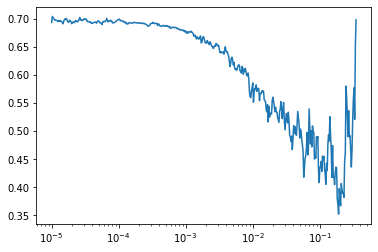

In [11]:
learner.lr_finder(bs=64, lr_range=(1e-5, 1e0))

In [18]:
learner.train(epochs=6, bs=64, grad_clip=(0.2, 0.4))

06/10/2020 17:11:55 INFO : Epoch : 1, batch : 78, train_loss = 0.6501, val_loss = 0.5972, val_accuracy : 0.684, time = 1s
06/10/2020 17:11:56 INFO : Epoch : 1, batch : 156, train_loss = 0.5378, val_loss = 0.5150, val_accuracy : 0.777, time = 2s
06/10/2020 17:11:57 INFO : Epoch : 1, batch : 234, train_loss = 0.4892, val_loss = 0.4877, val_accuracy : 0.790, time = 3s
06/10/2020 17:11:58 INFO : Epoch : 1, batch : 312, train_loss = 0.4770, val_loss = 0.4821, val_accuracy : 0.791, time = 5s
06/10/2020 17:12:00 INFO : Epoch : 2, batch : 78, train_loss = 0.4698, val_loss = 0.4699, val_accuracy : 0.800, time = 6s
06/10/2020 17:12:01 INFO : Epoch : 2, batch : 156, train_loss = 0.4473, val_loss = 0.4480, val_accuracy : 0.812, time = 7s
06/10/2020 17:12:02 INFO : Epoch : 2, batch : 234, train_loss = 0.4400, val_loss = 0.4404, val_accuracy : 0.814, time = 8s
06/10/2020 17:12:03 INFO : Epoch : 2, batch : 312, train_loss = 0.4315, val_loss = 0.4367, val_accuracy : 0.814, time = 9s
06/10/2020 17:12:0

In [19]:
model.embedding.weight.requires_grad_(True);
learner.train(epochs=5, bs=64, grad_clip=(0.2, 0.4))

06/10/2020 17:12:24 INFO : Epoch : 1, batch : 78, train_loss = 0.3712, val_loss = 0.3537, val_accuracy : 0.855, time = 2s
06/10/2020 17:12:25 INFO : Epoch : 1, batch : 156, train_loss = 0.3158, val_loss = 0.2985, val_accuracy : 0.883, time = 4s
06/10/2020 17:12:27 INFO : Epoch : 1, batch : 234, train_loss = 0.2840, val_loss = 0.2838, val_accuracy : 0.884, time = 6s
06/10/2020 17:12:29 INFO : Epoch : 1, batch : 312, train_loss = 0.2772, val_loss = 0.2794, val_accuracy : 0.884, time = 7s
06/10/2020 17:12:31 INFO : Epoch : 2, batch : 78, train_loss = 0.2059, val_loss = 0.2760, val_accuracy : 0.890, time = 9s
06/10/2020 17:12:33 INFO : Epoch : 2, batch : 156, train_loss = 0.2102, val_loss = 0.2631, val_accuracy : 0.890, time = 11s
06/10/2020 17:12:34 INFO : Epoch : 2, batch : 234, train_loss = 0.2063, val_loss = 0.2592, val_accuracy : 0.889, time = 13s
06/10/2020 17:12:36 INFO : Epoch : 2, batch : 312, train_loss = 0.1988, val_loss = 0.2573, val_accuracy : 0.891, time = 15s
06/10/2020 17:1

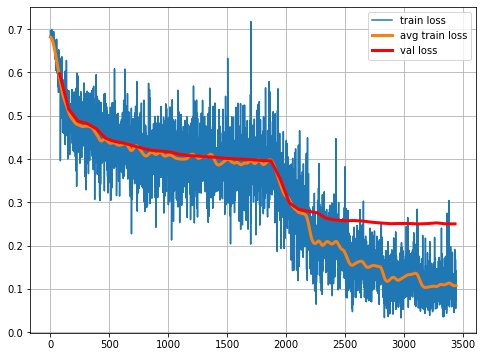

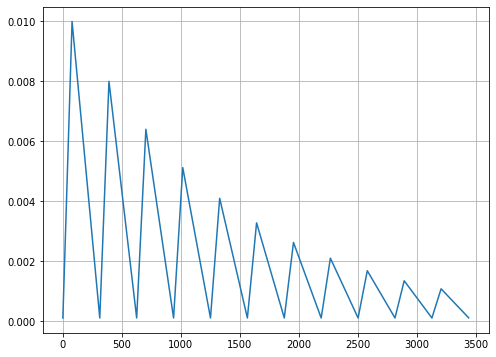

In [20]:
learner.recorder.plot_losses(show_lr=True)

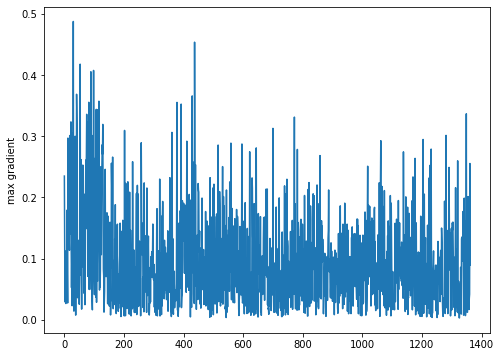

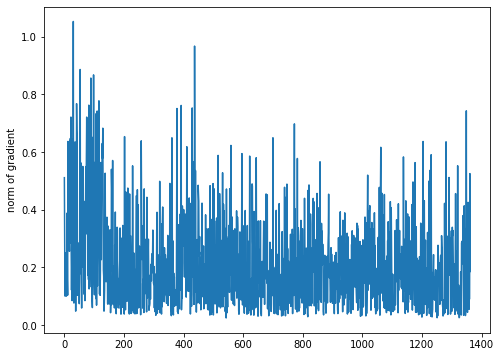

In [16]:
learner.recorder.plot_grads()

In [21]:
print('Test loss : {:.5f}, test accuracy : {:.03f}'.format(*validate(test_dataset, loss_fn, model, bs=64)))

Test loss : 0.28558, test accuracy : 0.884


In [0]:
if not os.path.exists('models'):
    os.makedirs('models')
torch.save(model.state_dict(), 'models/model_baseline.pt')